MAST query demo
==

The `mastquery` module packages some of the tools described in the [MastApi](https://mast.stsci.edu/api/v0/MastApiTutorial.html) into a more user-friendly wrapper for querying the Hubble archive.

Show observations around the "GN-z11" grism observations.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mastquery
from mastquery import query, utils
print('mastquery - version', mastquery.__version__)

mastquery - version 0.2.0


In [3]:
# Extra criteria: 
# science data only, HST (not HLA) products, no moving targets
print(query.DEFAULT_QUERY)

{'intentType': ['science'], 'mtFlag': ['False'], 'obs_collection': ['HST']}


In [4]:
# Query the GN-z11 program itself (GO-13871)
#
# Run with get_exptime to query the mast public website directly for exposure 
# times, since the API exposure times seem to be rather t_end - t_start, not
# accounting for dithers, orbits, etc.
tab = query.run_query(box=None, proposal_id=[13871], 
                      instruments=['WFC3/IR', 'ACS/WFC'], 
                      filters=['G141'], get_exptime=True,
                      base_query=query.DEFAULT_QUERY)

In [5]:
# Compute total exposure time by filter 
print('Filter  N   Texp')
print('===================')
for filt in np.unique(tab['filter']):
    sel = tab['filter'] == filt
    print('{0:5} {1:>5d} {2:>10.1f}'.format(filt, sel.sum(), tab['exptime'][sel].sum()))

Filter  N   Texp
G141      6    31870.5


In [6]:
# Search for additional observations around the pointing center
radius = 12 # arcmin, here large enough to get all of GOODS-N
box = [np.median(tab['ra']), np.median(tab['dec']), radius] 

filters = ['G102', 'F140W', 'F435W']
#filters = ['F140W']
extras = query.run_query(box=box, proposal_id=[], 
                         instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=filters, 
                         base_query=query.DEFAULT_QUERY)

/Users/gbrammer/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [7]:
print('Number of additional datasets: {0}'.format(len(extras)))

print('Filter  N   Texp')
print('===================')
for filt in np.unique(extras['filter']):
    sel = extras['filter'] == filt
    print('{0:5} {1:>5d} {2:>10.1f}'.format(filt, sel.sum(), extras['exptime'][sel].sum()))

Number of additional datasets: 216
Filter  N   Texp
F140W    56    44928.5
F435W    61   377334.0
G102     99   491335.9


G102 99
F140W 56
F435W 61


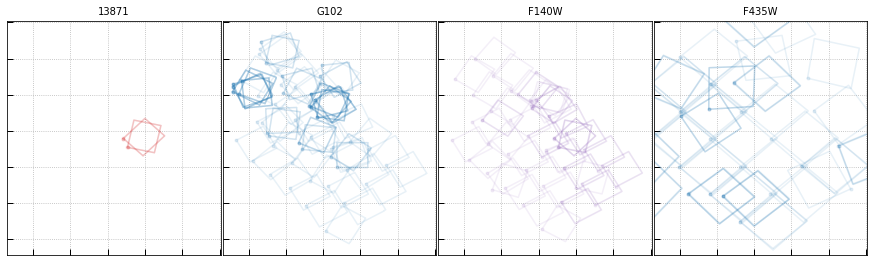

In [8]:
### Make a figure

fig = plt.figure(figsize=[12,3.5])

ax = fig.add_subplot(141)
query.show_footprints(tab, ax=ax)
ax.set_title('13871')

for i, filt in enumerate(filters):
    print(filt, (extras['filter'] == filt).sum())    
    ax = fig.add_subplot(142+i)
    query.show_footprints(extras[extras['filter'] == filt], ax=ax)
    ax.set_title(filt)

for ax in fig.axes:        
    ax.set_xlim(189.46939409999999, 188.89701790000001)
    ax.set_ylim(62.078094353454389, 62.402351754992722)
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout(pad=0.2)

## Find overlapping datasets

The example below shows how to 

  1) Perform a "parent" query for a specific program

  2) Break the "parent" into discrete groups of *overlapping* exposures

  3) Find any additional data that overlap with those groups

In [9]:
import numpy as np
from mastquery import query, overlaps

# Parent query is grism exposures from GO-14230
parent = query.run_query(box=None, proposal_id=[14230], 
                         instruments=['WFC3/IR'], 
                         filters=[], base_query=query.DEFAULT_QUERY)

print(len(parent))
print(np.unique(parent['filter']))
print(np.unique(parent['target']))

16
filters
-------
  F105W
  F140W
   G102
   G141
 target_name  
--------------
SDSSJ1723+3411
SDSSJ2340+2947


### The overlaps

The `overlaps.find_overlaps` first determines the overlapping groups from the `parent` table and then finds additional exposures that overlap with those groups.

The groups are assigned a name based on the coordinate center of the parent group like `jHHMMSS±DDMMSS`, and information of that group is stored to ascii and table files, along with a footprint figure.
    
    j172336+341156_footprint.fits # Table
    j172336+341156_footprint.npy  # Group polygon and [ra, dec, size] list
    j172336+341156_footprint.pdf  # Figure
    j172336+341156_info.dat       # Ascii report


Iter #1, N_Patch = 2


 0 j1724p3412 260.9006583333 34.19944444444
 target_name  
--------------
       CSWA-14
SDSSJ1723+3411 

filter j1724p3412         ACS/WFC F475W    1    2433.0
filter j1724p3412         ACS/WFC F606W    1    2433.0
filter j1724p3412         ACS/WFC F814W    1    2433.0
filter j1724p3412         WFC3/IR F105W    2     923.5
filter j1724p3412         WFC3/IR F110W    1    1111.8
filter j1724p3412         WFC3/IR F140W    2     923.5
filter j1724p3412         WFC3/IR F160W    1    1111.8
filter j1724p3412          WFC3/IR G102    2    9923.5
filter j1724p3412          WFC3/IR G141    2    9923.5
filter j1724p3412       WFC3/UVIS F390W    1    2368.0
filter j1724p3412       WFC3/UVIS F775W    1    2380.0


 1 j2340p2948 355.1191666667 29.7965
 target_name  
--------------
SDSSJ2340+2947 

filter j2340p2948         WFC3/IR F105W    2     973.5
filter j2340p2948         WFC3/IR F140W    2    1635.2
filter j2340p2948          WFC3/IR G102    2   10123.5
filter j2340p29

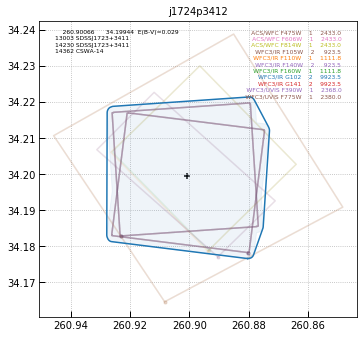

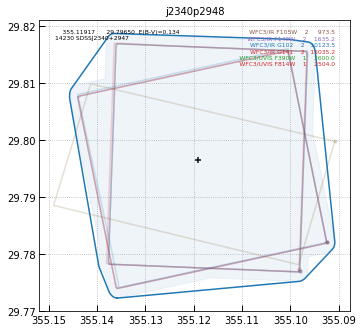

In [10]:
base_query = query.DEFAULT_QUERY
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.1, filters=[], 
                              proposal_id=[], 
                              instruments=query.ALL_INSTRUMENTS, 
                              base_query=base_query, close=False)

In [11]:
t = tabs[0]
for k in t.meta:
    print('\n{0:>8}: {1}'.format(k, t.meta[k]))


   qtime: ('Fri Oct 12 13:33:32 2018', 'Query timestamp')

    NAME: j1724p3412

      RA: 260.9006583333

     DEC: 34.19944444444

  MW_EBV: 0.0294

comments: ['--BEGIN-ASTROPY-SERIALIZED-COLUMNS--', 'datatype:', '- {name: dataproduct_type, datatype: string}', '- {name: calib_level, datatype: int64}', '- {name: obs_collection, datatype: string}', '- {name: obs_id, datatype: string}', '- {name: target, datatype: string}', '- {name: ra, datatype: float64, format: .6f}', '- {name: dec, datatype: float64, format: .6f}', '- {name: t_min, datatype: float64, format: .4f}', '- {name: t_max, datatype: float64, format: .4f}', '- {name: exptime, datatype: float64, format: .1f}', '- {name: wavelength_region, datatype: string}', '- {name: filter, datatype: string}', '- {name: em_min, datatype: float64}', '- {name: em_max, datatype: float64}', '- {name: target_classification, datatype: string}', '- {name: obs_title, datatype: string}', '- {name: t_obs_release, datatype: float64}', '- {name: instr

In [12]:
t[t['filter'] == 'G102'].show_in_notebook()

idx,dataproduct_type,calib_level,obs_collection,obs_id,target,ra,dec,t_min,t_max,exptime,wavelength_region,filter,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,footprint,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance,visit,area
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcmin2
0,image,3,HST,icwx04020,SDSSJ1723+3411,260.900658,34.199444,57580.6794,57580.5835,5111.7,Infrared,G102,1275.0,775.0,GALAXY;GRAVITATIONAL LENS;HIGH REDSHIFT GALAXY,The Ultimate Emission Line Diagnostics Study at z=1.4,57945.96809,WFC3/IR,"Rigby, Jane R.",14230,HST,GO,--,POLYGON -99.119698000000028 34.178183 -99.073984 34.182877 -99.0740175235243 34.183094854833747 -99.073860000000025 34.183111 -99.079056999999978 34.216876 -99.079508098726251 34.216829764270479 -99.079525999999987 34.216946 -99.125259000000028 34.21225 -99.125225191277053 34.21203123851074 -99.125383 34.212015 -99.120166999999981 34.178253 -99.119715975009086 34.178299398462663 -99.119698000000028 34.178183 -99.119698000000028 34.178183,--,mast:HST/product/icwx04020_drz.fits,PUBLIC,False,--,science,2004640017,2025176748,2025176748,0.0,04,4.8
1,image,3,HST,icwx05020,SDSSJ1723+3411,260.900658,34.199444,57406.1762,57406.0824,4811.7,Infrared,G102,1275.0,775.0,GALAXY;GRAVITATIONAL LENS;HIGH REDSHIFT GALAXY,The Ultimate Emission Line Diagnostics Study at z=1.4,57772.34309,WFC3/IR,"Rigby, Jane R.",14230,HST,GO,--,POLYGON -99.076862 34.182779 -99.076844678858322 34.182997973430034 -99.076686999999993 34.182989 -99.073999000000015 34.216956 -99.074452275100541 34.216981794992186 -99.074442999999974 34.217099 -99.120424000000014 34.219707 -99.120441207853688 34.219488079400783 -99.120599000000027 34.219497 -99.123269 34.185529 -99.122815777770668 34.1855033767687 -99.122824999999978 34.185386 -99.076862 34.182779 -99.076862 34.182779,--,mast:HST/product/icwx05020_drz.fits,PUBLIC,False,--,science,2004616309,2025595934,2025595934,0.0,05,4.8


In [13]:
if False:
    # COSMOS CANDELS + DASH
    from mastquery import query, overlaps
    parent = query.run_query(box=None, proposal_id=[14114,12440], 
                             instruments=['WFC3/IR'], 
                             extensions=['FLT'], filters=['F160W'], 
                             base_query=query.DEFAULT_QUERY)

    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.1, 
                                  filters=['F160W'],
                                  proposal_id=[], instruments=['WFC3/IR'], 
                                  base_query=query.DEFAULT_QUERY, 
                                  close=False)

### Fetch data
Fetch data directly from the ESA or stpubdata Amazon S3 archives.

To fetch from S3, you need to have the AWS command-line-interface installed and [configured](https://docs.aws.amazon.com/sdk-for-java/v1/developer-guide/setup-credentials.html) with your own AWS account credentials (i.e., in `~/.aws/credentials`).

In [14]:
import os
from mastquery import query, fetch

# GN-z11 dataset
tab = query.run_query(box=None, proposal_id=[13871], 
                      instruments=['WFC3/IR', 'ACS/WFC'], 
                      filters=['F140W','G141'], 
                      base_query=query.DEFAULT_QUERY)

print('Number of associations: {0}'.format(len(tab)))

Number of associations: 12


In [15]:
# Break associations into datasets
prod = query.get_products_table(tab[tab['visit'] == '01'], 
                                extensions=['RAW'])

print('Number of datasets: {0}'.format(len(prod)))
print(prod['observation_id','filter'])

Number of datasets: 8
observation_id filter
-------------- ------
     icka01t5q  F140W
     icka01t7q   G141
     icka01t8q   G141
     icka01tcq  F140W
     icka01tdq  F140W
     icka01tgq   G141
     icka01tiq   G141
     icka01tlq  F140W


In [16]:
s3_lines = fetch.make_curl_script(prod[:4], script_name=None, 
                                  s3_sync=True, output_path='.')

esa_lines = fetch.make_curl_script(prod[:4], script_name=None, 
                                   s3_sync=False, output_path='.')

print('# S3\n{0}\n\n# ESA archive\n{1}'.format(s3_lines[0], esa_lines[0]))

#status = os.system(s3_lines[0])
#!ls icka*raw.fits

# S3
aws s3 sync --request-payer requester --exclude="*.*" --include="*raw.fits" s3://stpubdata/hst/public/icka/icka01t5q/ ./

# ESA archive
curl http://archives.esac.esa.int/ehst-sl-server/servlet/data-action?ARTIFACT_ID=ICKA01T5Q_RAW.FITS -o ./icka01t5q_raw.fits.gz
